# To get started

In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import skimage

import imageio

import keras as k
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Input
from keras.models import Model
from keras.models import model_from_json

from PIL import Image
import cv2
from pathlib import Path

import datetime

The seedling images should be located in a folder called data. The seedling categories:
1. Black-grass
2. Charlock
3. Cleavers
4. Common Chickweed
5. Common wheat
6. Fat Hen
7. Loose Silky-bent
8. Maize
9. Scentless Mayweed
10. Shepherd'd Purse
11. Small-flowered Cranesbill
12. Sugar beet 
<br>


Within each seedling category, the images (pgn) are numbered 1,2,....

In [2]:
#Each of the images has a different shape but three channels, rbg
im1_path = os.path.join(".", "data", "Black-grass", "1.png")
im2_path = os.path.join(".", "data", "Black-grass", "7.png")
im3_path = os.path.join(".", "data", "Black-grass", "200.png")

im1 = imageio.imread(im1_path)
im2 = imageio.imread(im2_path)
im3 = imageio.imread(im3_path)
print(im1.shape)
print(im2.shape)
print(im3.shape)

(138, 138, 3)
(145, 145, 3)
(641, 641, 3)


Lets train a VGG16 model with weights pre-trained on ImageNet on all our categories.  We resize all images to 224X2254

In [8]:
# CREATING A SIMPLE CNN USING VGG16


#input layer description + creation
inLayer = Input(shape=(224, 224, 3))

#using the pretrained vgg16 model from keras
vgg = VGG16(weights = 'imagenet', include_top = False)
for l in vgg.layers :
    l.trainable = False

#building layers
cnn = (vgg)(inLayer)
flat = Flatten()(cnn)
model_with_fc = Dense(12)(flat)

#compile model
model = Model(inputs=inLayer, outputs = model_with_fc)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                301068    
Total params: 15,015,756
Trainable params: 301,068
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [9]:
# GENERATING TRAINING DATA 


#let's take 200 images from each category
trainImg = []
trainTarget = []

testImg = []
testTarget = []

# approx proportion of data that is test data
pTest = 0.2

catNames = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen", "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherd'd Purse", "Small-flowered Cranesbill", "Sugar beet"]
dataLoc = os.path.join(".", "data")
for cat in catNames:
    tv = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    tv[catNames.index(cat)] = 1
    for i in range (1,201):
        imgLoc = str(i)+".png"
        pathImg = os.path.join(dataLoc,cat,imgLoc)
        path = Path(pathImg)
        if(path.is_file()):
            im_frame = cv2.imread(pathImg)
            #resizing the image to 224, 224.  This is a basic solution to the issue to varying image size
            h, w = 224, 224
            res_im = cv2.resize(im_frame, (w,h), interpolation=cv2.INTER_LINEAR)
            if np.random.uniform() < pTest:
                testImg.append(res_im)
                testTarget.append(tv)
            else:
                trainImg.append(res_im)
                trainTarget.append(tv)

trainImg = np.array(trainImg)
trainTarget = np.array(trainTarget)

testImg = np.array(testImg)
testTarget = np.array(testTarget)

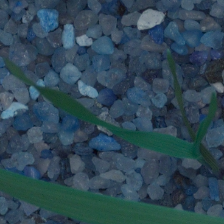

In [10]:
#show some images, change the 50 to display other images
image = Image.fromarray(trainImg[50])
image

In [12]:
#now, let's train our model
history = model.fit(trainImg, trainTarget, batch_size=10, epochs = 1)

Epoch 1/1
1739/1739 [==============================] - 736s 423ms/step - loss: 9.9911 - acc: 0.2553


In [15]:
# evalute model
scores = model.evaluate(testImg, testTarget, verbose=1)

410/410 [==============================] - 183s 446ms/step


In [34]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print(model.metrics_names)

acc: 29.02%
['loss', 'acc']


In [32]:
# Save Model
path_to_models = os.path.join(".", "models")
now = datetime.datetime.now()
date = now.strftime("%Y.%m.%d")
score_truncated = str(scores[1])[1:6]
name = os.path.join(path_to_models, "VGG16_acc" + score_truncated + "_" + date)


model_json = model.to_json()
with open(name + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(name + ".h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
loaded_model = None
with open(name + ".json", 'r') as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
score = loaded_model.evaluate(testImg, testTarget, verbose=1)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
352/410 [========================>.....] - ETA: 24s